(IN PROGRESS)

# Osmond and Coop 2024 (`spacetrees`) and Deraje et al. 2025 (`sparg`) - Brownian motion

Both of these papers use Brownian motion to model the movement of lineages. Osmond and Coop 2024 (`spacetrees`) sparsely samples gene trees, treating each tree independently. Deraje et al. 2025 (`sparg`) works on the full graph to account for the correlations between neighboring trees. When working on with a single tree, estimates from Deraje et al. match exactly with those from Osmond and Coop. Because of this, all calculations will be made using the `sparg` Python package from Deraje et al. 2025.

In [1]:
import sparg
import tskit
import numpy as np
import matplotlib.pyplot as plt
import tskit_arg_visualizer as argviz
import pandas as pd


def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=None):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb (optional) : bool
        Whether to add msprime node flags. Default is False.
    keep_nodes (optional) : list
        List of node IDs that should be kept. Default is None, so empty list.

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    if keep_nodes == None:
        keep_nodes = []

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.isin(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = 131072 #msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

Once again, we will work with the ten sample ARG from before, but this time we are going to use our custom simplification function to retain recombination nodes.

In [2]:
ts = tskit.load("continuous_space_ten_samples.trees")
ts_simple, maps_simple = simplify_with_recombination(ts, flag_recomb=True)

In [3]:
d3arg = argviz.D3ARG.from_ts(ts_simple)
d3arg.draw(width=500, height=500, edge_type="ortho")

In [4]:
spatial_arg = sparg.SpatialARG(ts=ts_simple)

Brownian motion models like `sparg` and `spacetrees` calculate the covariance between paths through the ARG. A reminder that a "path" is the sequence of edges that connects a node back to the root. In a tree, every sample has just one path, but in an ARG, each sample can have many paths. We can calculate the covariance between paths as the shared time across all of their edges muliplied by the dispersal rate. Deraje et al. 2025 shows that you also don't need every path through the ARG, only a minimal set due the non-independence between paths.

In [5]:
print("Minimal set of paths through the ARG:")
for path in spatial_arg.paths:
    print(np.array(path))

Minimal set of paths through the ARG:
[ 0 26 27 29 30 31]
[ 1 11 13 18 24 25 26 28 29 30 31]
[ 2 22 30 31]
[ 3 20 22 30 31]
[ 4 10 14 16 17 20 22 30 31]
[ 5 21 24 25 26 27 29 30 31]
[ 6 17 20 22 30 31]
[ 7 23 25 26 28 29 30 31]
[ 8 23 25 26 27 29 30 31]
[ 9 10 15 16 17 20 22 30 31]
[ 1 12 13 19 21 24 25 26 27 29 30 31]
[ 4 10 15 16 17 20 22 30 31]
[ 1 11 13 19 21 24 25 26 28 29 30 31]
[ 0 26 28 29 30 31]


The shared time matrix for paths [0,26,27,29,30,31] and [1,11,13,18,24,25,26,28,29,30,31] would look like...

In [6]:
print(spatial_arg.paths_shared_time_matrix[0:2,0:2])

[[9999. 5061.]
 [5061. 9999.]]


`sparg` estimates ancestral locations slightly differently than the previous methods. Rather than estimating the locations of nodes, `sparg` estimates the positions of lineages at specific times. This is nice for tracking lineages and is useful for showing how uncertainty changes along a branch length. Each block in the chromosome above follows a slightly different (but highly correlated) history, and we can track all of these at the same time.

In [7]:
genome_positions = []
previous_bp = None
for i,bp in enumerate(ts_simple.breakpoints()):
    if i > 0:
        genome_positions.append((bp + previous_bp) / 2)
    previous_bp = bp

Given these genome positions, the following block of code creates a `pandas.DataFrame` where each row is an ancestor of a sample at a specific time and for a specific region of the ARG.

In [8]:
samples = range(0,10)
times = range(0,10000,100)
data = []
for sample in samples:
  for pos in genome_positions:
    for time in times:
      data.append([sample,pos,time])
        
ancestors = pd.DataFrame(data, columns = ['sample','genome_position','time']) 

ancestor_locations = sparg.estimate_locations_of_ancestors_in_dataframe_using_arg(
    df=ancestors,
    spatial_arg=spatial_arg,
)

In [9]:
ancestor_locations

,sample,genome_position,time,position_in_arg,arg_estimated_location_0,arg_variance_in_estimated_location_0,arg_estimated_location_1,arg_variance_in_estimated_location_1
0,0,1031.0,0,1031.0,87.935951,-1.544999e-09,50.782751,-3.937316e-09
1,0,1031.0,100,1031.0,87.511074,9.163923e+00,50.764769,2.335358e+01
2,0,1031.0,200,1031.0,87.086197,1.805358e+01,50.746786,4.600821e+01
3,0,1031.0,300,1031.0,86.661320,2.666897e+01,50.728803,6.796390e+01
4,0,1031.0,400,1031.0,86.236443,3.501010e+01,50.710821,8.922065e+01
...,...,...,...,...,...,...,...,...
4995,9,9862.0,9500,9862.0,52.489505,4.296730e+02,53.223598,1.094990e+03
4996,9,9862.0,9600,9862.0,52.489505,4.389740e+02,53.223598,1.118693e+03
4997,9,9862.0,9700,9862.0,52.489505,4.482751e+02,53.223598,1.142396e+03
4998,9,9862.0,9800,9862.0,52.489505,4.575761e+02,53.223598,1.166099e+03


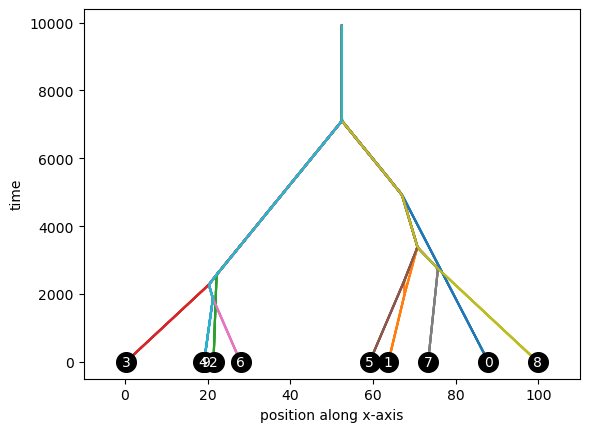

In [10]:
for gp in genome_positions:
    tree = ancestor_locations.loc[ancestor_locations["genome_position"]==gp]
    for label, df in tree.groupby("sample"):
        plt.plot(df.arg_estimated_location_0, df.time)

for sample in ts_simple.samples():
    location = ts.individual(ts.node(sample).individual).location
    plt.scatter(location[0], ts_simple.node(sample).time, s=200, color="black", zorder=2)
    plt.annotate(sample, (location[0], ts_simple.node(sample).time), ha="center", va="center", color="white")

plt.xlabel("position along x-axis")
plt.ylabel("time")
plt.xlim(-10, 110)
plt.show()

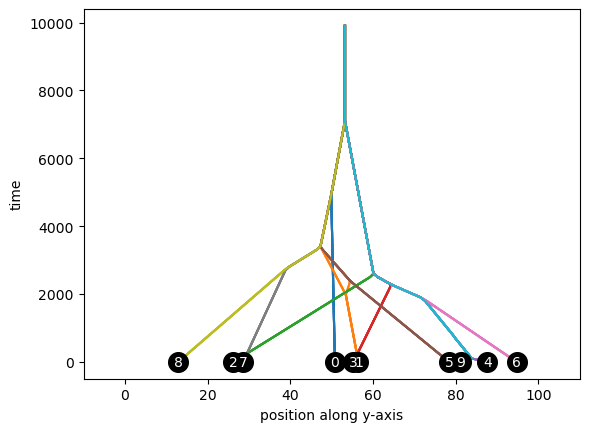

In [11]:
for gp in genome_positions:
    tree = ancestor_locations.loc[ancestor_locations["genome_position"]==gp]
    for label, df in tree.groupby("sample"):
        plt.plot(df.arg_estimated_location_1, df.time)

for sample in ts_simple.samples():
    location = ts.individual(ts.node(sample).individual).location
    plt.scatter(location[1], ts_simple.node(sample).time, s=200, color="black", zorder=2)
    plt.annotate(sample, (location[1], ts_simple.node(sample).time), ha="center", va="center", color="white")

plt.xlabel("position along y-axis")
plt.ylabel("time")
plt.xlim(-10, 110)
plt.show()

A major advantage of using a movement model to estimate locations is that it provides uncertainty to those estimates. Below, I've colored in two standard deviations on either side of the estimate. This helps to show just how quickly estimates can become fuzzy. Though we are simulating in a bounded area, movement under Brownian motion is not bounded, allowing the uncertainty to extend beyond 0 and 100. You can also see that uncertainty does not smoothly increase over time and instead has a bouncing pattern as more information is brought in at nodes, reducing the uncertainty.

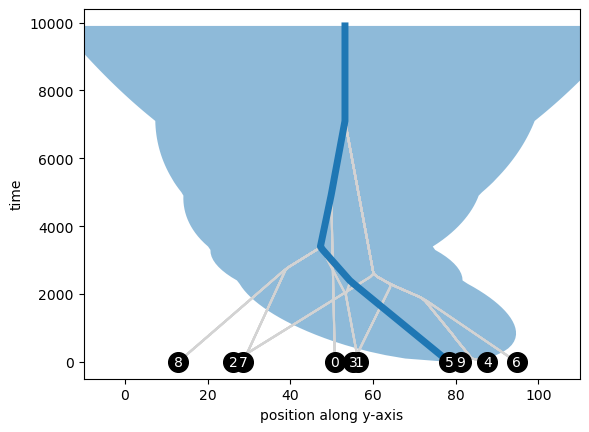

In [12]:
for gp in genome_positions:
    tree = ancestor_locations.loc[ancestor_locations["genome_position"]==gp]
    for label, df in tree.groupby("sample"):
        plt.plot(df.arg_estimated_location_1, df.time, color="lightgrey")
    if gp == 1031.0:
        only_sample_5 = tree.loc[tree["sample"]==5]
        plt.plot(only_sample_5.arg_estimated_location_1, only_sample_5.time, zorder=3, linewidth=5)
        plt.fill_betweenx(
            only_sample_5.time,
            only_sample_5.arg_estimated_location_1-np.sqrt(only_sample_5.arg_variance_in_estimated_location_1)*2,
            only_sample_5.arg_estimated_location_1+np.sqrt(only_sample_5.arg_variance_in_estimated_location_1)*2,
            alpha=0.5
        )

for sample in ts_simple.samples():
    location = ts.individual(ts.node(sample).individual).location
    plt.scatter(location[1], ts_simple.node(sample).time, s=200, color="black", zorder=4)
    plt.annotate(sample, (location[1], ts_simple.node(sample).time), ha="center", va="center", color="white", zorder=5)

plt.xlabel("position along y-axis")
plt.ylabel("time")
plt.xlim(-10, 110)
plt.show()

When `window_size=0`, `sparg` uses only the local tree to calculate the ancestral positions, not the graph. This is equivalent to Osmond and Coop 2024. We can add those esimates to our original `ancestor_locations` dataframe.

In [13]:
ancestor_locations = sparg.estimate_locations_of_ancestors_in_dataframe_using_window(
    df=ancestor_locations,
    spatial_arg=spatial_arg,
    window_size=0
)

Plotting these estimates shows that each tree provides slightly different estimates for the position of the lineage, driven by whether the lineage above sample 1 coalesces more quickly with the lineage above sample 5.

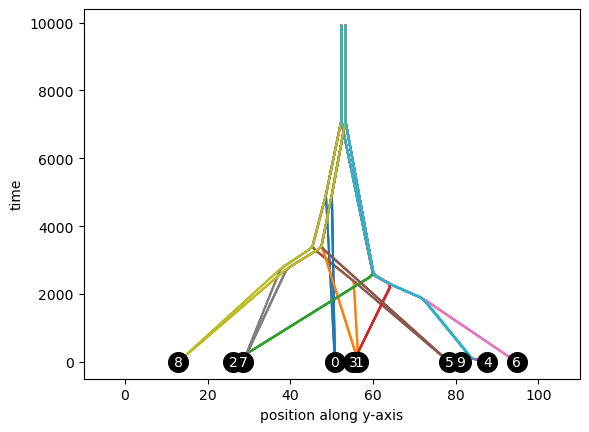

In [14]:
for gp in genome_positions:
    tree = ancestor_locations.loc[ancestor_locations["genome_position"]==gp]
    for label, df in tree.groupby("sample"):
        plt.plot(df.window_0_estimated_location_1, df.time)

for sample in ts_simple.samples():
    location = ts.individual(ts.node(sample).individual).location
    plt.scatter(location[1], ts_simple.node(sample).time, s=200, color="black", zorder=2)
    plt.annotate(sample, (location[1], ts_simple.node(sample).time), ha="center", va="center", color="white")

plt.xlabel("position along y-axis")
plt.ylabel("time")
plt.xlim(-10, 110)
plt.show()

Graph-based approaches theoretical provide more confidence (less uncertainty) in estimates as they include a greater number of connections in their calculations.

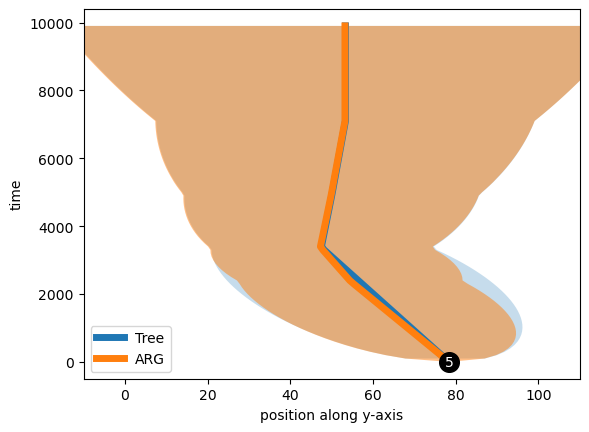

In [27]:
only_sample_5 = tree.loc[tree["sample"]==5]
plt.plot(only_sample_5.window_0_estimated_location_1, only_sample_5.time, zorder=3, linewidth=5, label="Tree")
plt.fill_betweenx(
    only_sample_5.time,
    only_sample_5.window_0_estimated_location_1-np.sqrt(only_sample_5.window_0_variance_in_estimated_location_1)*2,
    only_sample_5.window_0_estimated_location_1+np.sqrt(only_sample_5.window_0_variance_in_estimated_location_1)*2,
    alpha=0.25
)

plt.plot(only_sample_5.arg_estimated_location_1, only_sample_5.time, zorder=3, linewidth=5, label="ARG")
plt.fill_betweenx(
    only_sample_5.time,
    only_sample_5.arg_estimated_location_1-np.sqrt(only_sample_5.arg_variance_in_estimated_location_1)*2,
    only_sample_5.arg_estimated_location_1+np.sqrt(only_sample_5.arg_variance_in_estimated_location_1)*2,
    alpha=0.5
)

location = ts.individual(ts.node(5).individual).location
plt.scatter(location[1], ts_simple.node(sample).time, s=200, color="black", zorder=4)
plt.annotate(5, (location[1], ts_simple.node(5).time), ha="center", va="center", color="white", zorder=5)

plt.xlabel("position along y-axis")
plt.ylabel("time")
plt.xlim(-10, 110)
plt.legend()
plt.show()

Large biases arise when applying Brownian motion to graphs (see Deraje et al. 2025), so these plots should be used as a theoretical comparison of graph versus tree approaches rather than a statement about the usefulness of Brownian motion in this context.